<a href="https://colab.research.google.com/github/theoVasilas/Diplomatic_incident/blob/Centralized-training/Centralized_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installations

In [29]:
from collections import OrderedDict, Counter
from typing import Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,random_split

import torchvision
from torch.utils.data import DataLoader
import torch.optim as optim
import time
import pandas as pd
import torchvision.datasets as datasets
from IPython import display
print(f"Pytorch Version:{torch.__version__}")

DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(f"Training on {DEVICE}")


Pytorch Version:2.5.1+cu121
Training on cpu


# Dataloader


In [30]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=50000, shuffle=False)

# Get all images in the training set
data = next(iter(trainloader))[0]  # Images only (shape: [50000, 3, 32, 32])

# Calculate mean and std for each channel
mean = data.mean(dim=[0, 2, 3])  # Mean across batches, height, and width
std = data.std(dim=[0, 2, 3])    # Std across batches, height, and width

print(f"Mean: {mean}, Std: {std}")

Files already downloaded and verified
Mean: tensor([0.4914, 0.4822, 0.4465]), Std: tensor([0.2470, 0.2435, 0.2616])


In [31]:
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # Data augmentation: random cropping
    transforms.RandomHorizontalFlip(),    # Data augmentation: random horizontal flip
    transforms.ToTensor(),
    transforms.Normalize(mean, std)  # Normalize with CIFAR-10 stats
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

train_size = int(0.8 * len(trainset))  # 80% of the dataset for training
val_size = len(trainset) - train_size  # Remaining 20% for validation

train_subset, val_subset = random_split(trainset, [train_size, val_size])

trainloader = DataLoader(train_subset, batch_size=128, shuffle=True, num_workers=2)
valloader = DataLoader(val_subset, batch_size=128, shuffle=False, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

print(f"Training samples: {len(trainloader.dataset)}")
print(f"Validation samples: {len(valloader.dataset)}")
print(f"Test samples: {len(testloader.dataset)}")


Files already downloaded and verified
Files already downloaded and verified
Training samples: 40000
Validation samples: 10000
Test samples: 10000


In [32]:
print("CIFAR-10 Classes:", trainset.classes)

CIFAR-10 Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# train test Func


/+ StepLR scheduler

In [59]:
from tqdm import tqdm  # For progress bars

def train(
    net,
    trainloader,
    valloader,
    optimizer,
    step_size,
    epochs: int,
    verbose=False
):

    criterion = torch.nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)  # Optional scheduler
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    # Training loop
    for epoch in range(epochs):
        lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{epochs} - Learning Rate: {lr}")

        net.train()
        train_loss, train_correct, train_total = 0.0, 0, 0

        # Training Phase
        for images, labels in tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs} (Training)"):
            try:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                optimizer.zero_grad()
                outputs = net(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # Metrics
                train_loss += loss.item()
                train_total += labels.size(0)
                predictions = torch.argmax(outputs, dim=1)
                train_correct += (predictions == labels).sum().item()
            except Exception as e:
                print(f"Error in training step: {e}")

        # if (epoch + 1) % 10 == 0:
        #     filename = f'checkpoint_epoch_{epoch+1}.pth'
        #     torch.save(net, filename)
        #     print(f"Entire model saved to {filename}")

        # Compute averages
        train_loss /= len(trainloader)
        train_acc = train_correct / train_total

        # Validation Phase
        net.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in tqdm(valloader, desc=f"Epoch {epoch+1}/{epochs} (Validation)"):
                try:
                    images, labels = images.to(DEVICE), labels.to(DEVICE)
                    outputs = net(images)
                    loss = criterion(outputs, labels)

                    # Metrics
                    val_loss += loss.item()
                    val_total += labels.size(0)
                    predictions = torch.argmax(outputs, dim=1)
                    val_correct += (predictions == labels).sum().item()
                except Exception as e:
                    print(f"Error in validation step: {e}")

        # Compute averages
        val_loss /= len(valloader)
        val_acc = val_correct / val_total

        # Step the scheduler
        scheduler.step()

        # Save metrics to history
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # Verbose logging
        if verbose:
            print(
                f"Epoch {epoch+1}/{epochs} "
                f"- Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} "
                f"- Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
            )

        if val_acc >= 0.90:
              print(f"Early stopping: Validation accuracy reached {accuracy_threshold*100}%")
              break

    return history


In [34]:
def test(net, testloader):
    criterion = torch.nn.CrossEntropyLoss()
    net.eval()  # Set the model to evaluation mode
    test_loss, test_correct, test_total = 0.0, 0, 0

    with torch.no_grad():  # No gradient calculation during testing
        for images, labels in tqdm(testloader, desc="Testing"):
            try:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = net(images)
                loss = criterion(outputs, labels)

                # Metrics
                test_loss += loss.item()
                test_total += labels.size(0)
                predictions = torch.argmax(outputs, dim=1)
                test_correct += (predictions == labels).sum().item()
            except Exception as e:
                print(f"Error in testing step: {e}")

    # Compute averages
    test_loss /= len(testloader)
    test_acc = test_correct / test_total

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

    return test_loss, test_acc


# Model 1

In [55]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def reset(self):
      for layer in self.children():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
          layer.reset_parameters()

In [56]:
model = Net()
num_parameters = sum(value.numel() for value in model.state_dict().values())
print(f"{num_parameters = }")

num_parameters = 62006


## Run

Epoch 1/50 - Learning Rate: 0.01


Epoch 1/50 (Validation): 100%|██████████| 79/79 [00:04<00:00, 16.36it/s]


Epoch 1/50 - Train Loss: 2.0288, Train Acc: 0.2441 - Val Loss: 1.7942, Val Acc: 0.3409
Epoch 2/50 - Learning Rate: 0.01


Epoch 2/50 (Validation): 100%|██████████| 79/79 [00:04<00:00, 16.81it/s]


Epoch 2/50 - Train Loss: 1.6740, Train Acc: 0.3766 - Val Loss: 1.5920, Val Acc: 0.4030
Epoch 3/50 - Learning Rate: 0.01


Epoch 3/50 (Validation): 100%|██████████| 79/79 [00:04<00:00, 16.97it/s]


Epoch 3/50 - Train Loss: 1.5494, Train Acc: 0.4333 - Val Loss: 1.4711, Val Acc: 0.4634
Epoch 4/50 - Learning Rate: 0.01


Epoch 4/50 (Validation): 100%|██████████| 79/79 [00:04<00:00, 16.85it/s]


Epoch 4/50 - Train Loss: 1.4389, Train Acc: 0.4793 - Val Loss: 1.4769, Val Acc: 0.4812
Epoch 5/50 - Learning Rate: 0.01


Epoch 5/50 (Validation): 100%|██████████| 79/79 [00:04<00:00, 17.07it/s]


Epoch 5/50 - Train Loss: 1.3684, Train Acc: 0.5090 - Val Loss: 1.3239, Val Acc: 0.5211
Epoch 6/50 - Learning Rate: 0.01


Epoch 6/50 (Validation): 100%|██████████| 79/79 [00:04<00:00, 17.20it/s]


Epoch 6/50 - Train Loss: 1.3225, Train Acc: 0.5269 - Val Loss: 1.3845, Val Acc: 0.5054
Epoch 7/50 - Learning Rate: 0.01


Epoch 7/50 (Validation): 100%|██████████| 79/79 [00:04<00:00, 16.66it/s]


Epoch 7/50 - Train Loss: 1.2728, Train Acc: 0.5458 - Val Loss: 1.2947, Val Acc: 0.5362
Epoch 8/50 - Learning Rate: 0.01


Epoch 8/50 (Validation): 100%|██████████| 79/79 [00:05<00:00, 13.36it/s]


Epoch 8/50 - Train Loss: 1.2291, Train Acc: 0.5603 - Val Loss: 1.2665, Val Acc: 0.5471
Epoch 9/50 - Learning Rate: 0.01


Epoch 9/50 (Validation): 100%|██████████| 79/79 [00:04<00:00, 16.61it/s]


Epoch 9/50 - Train Loss: 1.2095, Train Acc: 0.5708 - Val Loss: 1.2183, Val Acc: 0.5745
Epoch 10/50 - Learning Rate: 0.01


Epoch 10/50 (Validation): 100%|██████████| 79/79 [00:06<00:00, 13.16it/s]


Epoch 10/50 - Train Loss: 1.1798, Train Acc: 0.5789 - Val Loss: 1.1926, Val Acc: 0.5772
Epoch 11/50 - Learning Rate: 0.005


Epoch 11/50 (Validation): 100%|██████████| 79/79 [00:06<00:00, 11.98it/s]


Epoch 11/50 - Train Loss: 1.1170, Train Acc: 0.6043 - Val Loss: 1.1904, Val Acc: 0.5737
Epoch 12/50 - Learning Rate: 0.005


Epoch 12/50 (Validation): 100%|██████████| 79/79 [00:07<00:00, 11.23it/s]


Epoch 12/50 - Train Loss: 1.0936, Train Acc: 0.6103 - Val Loss: 1.1753, Val Acc: 0.5796
Epoch 13/50 - Learning Rate: 0.005


Epoch 13/50 (Validation): 100%|██████████| 79/79 [00:05<00:00, 13.39it/s]


Epoch 13/50 - Train Loss: 1.0808, Train Acc: 0.6152 - Val Loss: 1.1713, Val Acc: 0.5900
Epoch 14/50 - Learning Rate: 0.005


Epoch 14/50 (Validation): 100%|██████████| 79/79 [00:05<00:00, 14.98it/s]


Epoch 14/50 - Train Loss: 1.0768, Train Acc: 0.6177 - Val Loss: 1.1480, Val Acc: 0.5936
Epoch 15/50 - Learning Rate: 0.005


Epoch 15/50 (Validation): 100%|██████████| 79/79 [00:05<00:00, 13.97it/s]


Epoch 15/50 - Train Loss: 1.0634, Train Acc: 0.6243 - Val Loss: 1.1260, Val Acc: 0.6026
Epoch 16/50 - Learning Rate: 0.005


Epoch 16/50 (Validation): 100%|██████████| 79/79 [00:04<00:00, 16.56it/s]


Epoch 16/50 - Train Loss: 1.0567, Train Acc: 0.6251 - Val Loss: 1.1137, Val Acc: 0.6079
Epoch 17/50 - Learning Rate: 0.005


Epoch 17/50 (Validation): 100%|██████████| 79/79 [00:04<00:00, 17.10it/s]


Epoch 17/50 - Train Loss: 1.0473, Train Acc: 0.6299 - Val Loss: 1.1209, Val Acc: 0.6042
Epoch 18/50 - Learning Rate: 0.005


Epoch 18/50 (Validation): 100%|██████████| 79/79 [00:04<00:00, 17.02it/s]


Epoch 18/50 - Train Loss: 1.0394, Train Acc: 0.6292 - Val Loss: 1.0892, Val Acc: 0.6164
Epoch 19/50 - Learning Rate: 0.005


Epoch 19/50 (Validation): 100%|██████████| 79/79 [00:04<00:00, 17.19it/s]


Epoch 19/50 - Train Loss: 1.0320, Train Acc: 0.6328 - Val Loss: 1.0958, Val Acc: 0.6114
Epoch 20/50 - Learning Rate: 0.005


Epoch 20/50 (Validation): 100%|██████████| 79/79 [00:04<00:00, 17.15it/s]


Epoch 20/50 - Train Loss: 1.0304, Train Acc: 0.6348 - Val Loss: 1.0731, Val Acc: 0.6209
Epoch 21/50 - Learning Rate: 0.0025


Epoch 21/50 (Validation): 100%|██████████| 79/79 [00:04<00:00, 17.21it/s]


Epoch 21/50 - Train Loss: 0.9839, Train Acc: 0.6498 - Val Loss: 1.0609, Val Acc: 0.6261
Epoch 22/50 - Learning Rate: 0.0025


Epoch 22/50 (Validation): 100%|██████████| 79/79 [00:04<00:00, 16.70it/s]


Epoch 22/50 - Train Loss: 0.9792, Train Acc: 0.6540 - Val Loss: 1.0584, Val Acc: 0.6221
Epoch 23/50 - Learning Rate: 0.0025


Epoch 23/50 (Validation): 100%|██████████| 79/79 [00:04<00:00, 16.68it/s]


Epoch 23/50 - Train Loss: 0.9802, Train Acc: 0.6523 - Val Loss: 1.0485, Val Acc: 0.6341
Epoch 24/50 - Learning Rate: 0.0025


Epoch 24/50 (Validation): 100%|██████████| 79/79 [00:04<00:00, 16.91it/s]


Epoch 24/50 - Train Loss: 0.9720, Train Acc: 0.6550 - Val Loss: 1.0261, Val Acc: 0.6365
Epoch 25/50 - Learning Rate: 0.0025


Epoch 25/50 (Validation): 100%|██████████| 79/79 [00:05<00:00, 13.36it/s]


Epoch 25/50 - Train Loss: 0.9712, Train Acc: 0.6567 - Val Loss: 1.0368, Val Acc: 0.6344
Epoch 26/50 - Learning Rate: 0.0025


Epoch 26/50 (Validation): 100%|██████████| 79/79 [00:06<00:00, 11.80it/s]


Epoch 26/50 - Train Loss: 0.9614, Train Acc: 0.6617 - Val Loss: 1.0584, Val Acc: 0.6248
Epoch 27/50 - Learning Rate: 0.0025


Epoch 27/50 (Validation): 100%|██████████| 79/79 [00:08<00:00,  9.46it/s]


Epoch 27/50 - Train Loss: 0.9589, Train Acc: 0.6568 - Val Loss: 1.0192, Val Acc: 0.6409
Epoch 28/50 - Learning Rate: 0.0025


Epoch 28/50 (Validation): 100%|██████████| 79/79 [00:06<00:00, 13.12it/s]


Epoch 28/50 - Train Loss: 0.9595, Train Acc: 0.6575 - Val Loss: 1.0261, Val Acc: 0.6407
Epoch 29/50 - Learning Rate: 0.0025


Epoch 29/50 (Validation): 100%|██████████| 79/79 [00:05<00:00, 14.49it/s]


Epoch 29/50 - Train Loss: 0.9522, Train Acc: 0.6600 - Val Loss: 1.0303, Val Acc: 0.6405
Epoch 30/50 - Learning Rate: 0.0025


Epoch 30/50 (Validation): 100%|██████████| 79/79 [00:04<00:00, 17.02it/s]


Epoch 30/50 - Train Loss: 0.9542, Train Acc: 0.6604 - Val Loss: 1.0230, Val Acc: 0.6426
Epoch 31/50 - Learning Rate: 0.00125


Epoch 31/50 (Validation): 100%|██████████| 79/79 [00:04<00:00, 17.27it/s]


Epoch 31/50 - Train Loss: 0.9275, Train Acc: 0.6692 - Val Loss: 1.0051, Val Acc: 0.6499
Epoch 32/50 - Learning Rate: 0.00125


Epoch 32/50 (Validation): 100%|██████████| 79/79 [00:04<00:00, 17.07it/s]


Epoch 32/50 - Train Loss: 0.9273, Train Acc: 0.6695 - Val Loss: 1.0053, Val Acc: 0.6443
Epoch 33/50 - Learning Rate: 0.00125


Epoch 33/50 (Validation): 100%|██████████| 79/79 [00:04<00:00, 17.01it/s]


Epoch 33/50 - Train Loss: 0.9226, Train Acc: 0.6703 - Val Loss: 0.9973, Val Acc: 0.6421
Epoch 34/50 - Learning Rate: 0.00125


Epoch 34/50 (Validation): 100%|██████████| 79/79 [00:04<00:00, 17.13it/s]


Epoch 34/50 - Train Loss: 0.9197, Train Acc: 0.6733 - Val Loss: 1.0026, Val Acc: 0.6516
Epoch 35/50 - Learning Rate: 0.00125


Epoch 35/50 (Validation): 100%|██████████| 79/79 [00:04<00:00, 16.85it/s]


Epoch 35/50 - Train Loss: 0.9197, Train Acc: 0.6715 - Val Loss: 1.0023, Val Acc: 0.6504
Epoch 36/50 - Learning Rate: 0.00125


Epoch 36/50 (Validation): 100%|██████████| 79/79 [00:06<00:00, 13.15it/s]


Epoch 36/50 - Train Loss: 0.9177, Train Acc: 0.6738 - Val Loss: 1.0028, Val Acc: 0.6436
Epoch 37/50 - Learning Rate: 0.00125


Epoch 37/50 (Validation): 100%|██████████| 79/79 [00:04<00:00, 16.56it/s]


Epoch 37/50 - Train Loss: 0.9120, Train Acc: 0.6776 - Val Loss: 0.9913, Val Acc: 0.6514
Epoch 38/50 - Learning Rate: 0.00125


Epoch 38/50 (Validation): 100%|██████████| 79/79 [00:04<00:00, 16.57it/s]


Epoch 38/50 - Train Loss: 0.9196, Train Acc: 0.6701 - Val Loss: 0.9936, Val Acc: 0.6534
Epoch 39/50 - Learning Rate: 0.00125


Epoch 39/50 (Validation): 100%|██████████| 79/79 [00:05<00:00, 13.38it/s]


Epoch 39/50 - Train Loss: 0.9113, Train Acc: 0.6748 - Val Loss: 0.9996, Val Acc: 0.6509
Epoch 40/50 - Learning Rate: 0.00125


Epoch 40/50 (Validation): 100%|██████████| 79/79 [00:06<00:00, 11.79it/s]


Epoch 40/50 - Train Loss: 0.9148, Train Acc: 0.6740 - Val Loss: 0.9861, Val Acc: 0.6543
Epoch 41/50 - Learning Rate: 0.000625


Epoch 41/50 (Validation): 100%|██████████| 79/79 [00:06<00:00, 11.51it/s]


Epoch 41/50 - Train Loss: 0.9018, Train Acc: 0.6776 - Val Loss: 1.0061, Val Acc: 0.6491
Epoch 42/50 - Learning Rate: 0.000625


Epoch 42/50 (Validation): 100%|██████████| 79/79 [00:06<00:00, 11.70it/s]


Epoch 42/50 - Train Loss: 0.8990, Train Acc: 0.6795 - Val Loss: 0.9811, Val Acc: 0.6560
Epoch 43/50 - Learning Rate: 0.000625


Epoch 43/50 (Validation): 100%|██████████| 79/79 [00:06<00:00, 11.64it/s]


Epoch 43/50 - Train Loss: 0.9014, Train Acc: 0.6807 - Val Loss: 0.9900, Val Acc: 0.6529
Epoch 44/50 - Learning Rate: 0.000625


Epoch 44/50 (Validation): 100%|██████████| 79/79 [00:05<00:00, 13.72it/s]


Epoch 44/50 - Train Loss: 0.8900, Train Acc: 0.6840 - Val Loss: 0.9776, Val Acc: 0.6580
Epoch 45/50 - Learning Rate: 0.000625


Epoch 45/50 (Validation): 100%|██████████| 79/79 [00:05<00:00, 14.31it/s]


Epoch 45/50 - Train Loss: 0.8917, Train Acc: 0.6810 - Val Loss: 0.9903, Val Acc: 0.6539
Epoch 46/50 - Learning Rate: 0.000625


Epoch 46/50 (Validation): 100%|██████████| 79/79 [00:04<00:00, 17.05it/s]


Epoch 46/50 - Train Loss: 0.8896, Train Acc: 0.6844 - Val Loss: 0.9813, Val Acc: 0.6515
Epoch 47/50 - Learning Rate: 0.000625


Epoch 47/50 (Validation): 100%|██████████| 79/79 [00:04<00:00, 17.04it/s]


Epoch 47/50 - Train Loss: 0.8869, Train Acc: 0.6845 - Val Loss: 0.9813, Val Acc: 0.6566
Epoch 48/50 - Learning Rate: 0.000625


Epoch 48/50 (Validation): 100%|██████████| 79/79 [00:04<00:00, 17.13it/s]


Epoch 48/50 - Train Loss: 0.8885, Train Acc: 0.6835 - Val Loss: 0.9803, Val Acc: 0.6567
Epoch 49/50 - Learning Rate: 0.000625


Epoch 49/50 (Validation): 100%|██████████| 79/79 [00:04<00:00, 17.27it/s]


Epoch 49/50 - Train Loss: 0.8858, Train Acc: 0.6858 - Val Loss: 0.9909, Val Acc: 0.6511
Epoch 50/50 - Learning Rate: 0.000625


Epoch 50/50 (Validation): 100%|██████████| 79/79 [00:04<00:00, 17.04it/s]


Epoch 50/50 - Train Loss: 0.8889, Train Acc: 0.6846 - Val Loss: 0.9729, Val Acc: 0.6594


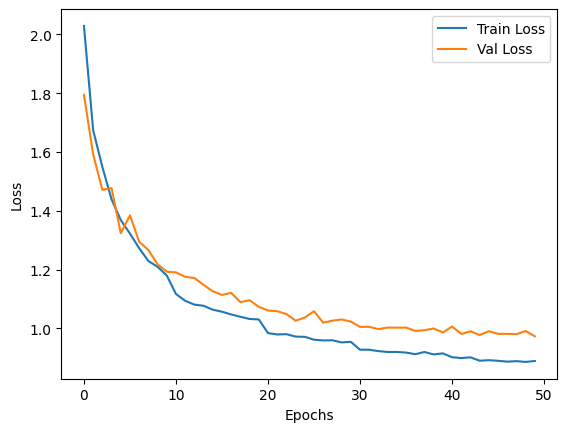

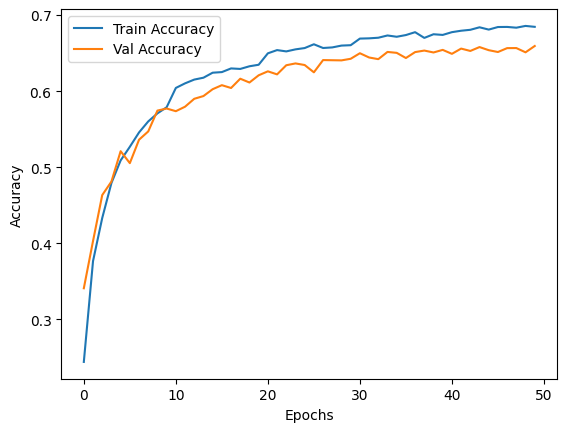

In [60]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.reset()  # Reset the model

model = Net().to(DEVICE)

# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

history = train(model, trainloader, valloader, optimizer,step_size=25 , epochs=50, verbose=True)

plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(history["train_acc"], label="Train Accuracy")
plt.plot(history["val_acc"], label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## test

In [ ]:
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)
test_loss, test_acc = test(model, testloader)


## save model

In [ ]:
filename = 'cifar10_model.pth'

torch.save(model.state_dict(), filename)
print(f"Model saved to {filename}")

In [ ]:
# net = torch.load(filename)
# net.eval()
# print(f"Model loaded from {filename}")

## statistics


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

model.eval()  # Set model to evaluation mode
all_labels = []
all_preds = []

misclassified_images = []
misclassified_labels = []
misclassified_preds = []

with torch.no_grad():
    for images, labels in tqdm(testloader, desc="Computing Confusion Matrix"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())  # Collect all true labels
        all_preds.extend(preds.cpu().numpy())    # Collect all predictions

        # Find misclassified images
        incorrect = preds != labels
        misclassified_images.extend(images[incorrect].cpu())  # Collect misclassified images
        misclassified_labels.extend(labels[incorrect].cpu())  # True labels of misclassified images
        misclassified_preds.extend(preds[incorrect].cpu())  # Predicted labels of misclassified images



In [ ]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Calculate accuracy for each class
class_accuracies = np.diag(cm) / cm.sum(axis=1)
for i, acc in enumerate(class_accuracies):
    print(f'Accuracy for class {i}: {acc:.2f}')

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=testloader.dataset.classes, yticklabels=testloader.dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
mean = torch.tensor([0.5, 0.5, 0.5])
std = torch.tensor([0.5, 0.5, 0.5])

num_images = 10

for i in range(num_images):
    # Create a new figure for each image
    plt.figure(figsize=(3, 3))

    image = misclassified_images[i].permute(1, 2, 0)  # Convert to (H, W, C)
    image = image * std + mean  # Unnormalize
    image = image.numpy()  # Convert to numpy
    image = np.clip(image, 0, 1)  # Ensure values are in [0, 1]

    plt.imshow(image)
    plt.title(f"True: {misclassified_labels[i]}, Pred: {misclassified_preds[i]}")
    plt.axis('off')  # Hide axes
    plt.show()  # Show each image independently

# Model 2



## ShufflnetV2

In [45]:
from torchvision.models import shufflenet_v2_x1_0

model_2 = shufflenet_v2_x1_0(pretrained=True)

num_classes = 10
model_2.fc = torch.nn.Linear(model_2.fc.in_features, num_classes)

num_parameters = sum(value.numel() for value in model_2.state_dict().values())
print(f"Number of parameters: {num_parameters / 10**6:.2f}M")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth
100%|██████████| 8.79M/8.79M [00:00<00:00, 25.4MB/s]

Number of parameters: 1.28M


## train


Epoch 1/20 - Learning Rate: 0.01


Epoch 1/20 (Validation): 100%|██████████| 79/79 [00:10<00:00,  7.30it/s]


Epoch 1/20 - Train Loss: 2.1166, Train Acc: 0.3169 - Val Loss: 1.7539, Val Acc: 0.4470
Epoch 2/20 - Learning Rate: 0.01


Epoch 2/20 (Validation): 100%|██████████| 79/79 [00:11<00:00,  6.92it/s]


Epoch 2/20 - Train Loss: 1.3311, Train Acc: 0.5451 - Val Loss: 1.0979, Val Acc: 0.6165
Epoch 3/20 - Learning Rate: 0.01


Epoch 3/20 (Validation): 100%|██████████| 79/79 [00:08<00:00,  8.85it/s]


Epoch 3/20 - Train Loss: 0.9973, Train Acc: 0.6548 - Val Loss: 0.9302, Val Acc: 0.6743
Epoch 4/20 - Learning Rate: 0.01


Epoch 4/20 (Validation): 100%|██████████| 79/79 [00:10<00:00,  7.40it/s]


Epoch 4/20 - Train Loss: 0.8759, Train Acc: 0.6966 - Val Loss: 0.8622, Val Acc: 0.6994
Epoch 5/20 - Learning Rate: 0.01


Epoch 5/20 (Validation): 100%|██████████| 79/79 [00:10<00:00,  7.33it/s]


Epoch 5/20 - Train Loss: 0.8177, Train Acc: 0.7141 - Val Loss: 0.8133, Val Acc: 0.7163
Epoch 6/20 - Learning Rate: 0.01


Epoch 6/20 (Validation): 100%|██████████| 79/79 [00:09<00:00,  8.67it/s]


Epoch 6/20 - Train Loss: 0.7695, Train Acc: 0.7327 - Val Loss: 0.7775, Val Acc: 0.7311
Epoch 7/20 - Learning Rate: 0.01


Epoch 7/20 (Validation): 100%|██████████| 79/79 [00:09<00:00,  8.42it/s]


Epoch 7/20 - Train Loss: 0.7325, Train Acc: 0.7425 - Val Loss: 0.7494, Val Acc: 0.7354
Epoch 8/20 - Learning Rate: 0.01


Epoch 8/20 (Validation): 100%|██████████| 79/79 [00:10<00:00,  7.20it/s]


Epoch 8/20 - Train Loss: 0.7078, Train Acc: 0.7543 - Val Loss: 0.7204, Val Acc: 0.7422
Epoch 9/20 - Learning Rate: 0.01


Epoch 9/20 (Validation): 100%|██████████| 79/79 [00:10<00:00,  7.38it/s]


Epoch 9/20 - Train Loss: 0.6814, Train Acc: 0.7625 - Val Loss: 0.7181, Val Acc: 0.7500
Epoch 10/20 - Learning Rate: 0.01


Epoch 10/20 (Validation): 100%|██████████| 79/79 [00:08<00:00,  8.96it/s]


Epoch 10/20 - Train Loss: 0.6646, Train Acc: 0.7652 - Val Loss: 0.7325, Val Acc: 0.7462
Epoch 11/20 - Learning Rate: 0.005


Epoch 11/20 (Validation): 100%|██████████| 79/79 [00:11<00:00,  6.66it/s]


Epoch 11/20 - Train Loss: 0.6228, Train Acc: 0.7833 - Val Loss: 0.6728, Val Acc: 0.7694
Epoch 12/20 - Learning Rate: 0.005


Epoch 12/20 (Validation): 100%|██████████| 79/79 [00:11<00:00,  7.14it/s]


Epoch 12/20 - Train Loss: 0.5993, Train Acc: 0.7899 - Val Loss: 0.6670, Val Acc: 0.7649
Epoch 13/20 - Learning Rate: 0.005


Epoch 13/20 (Validation): 100%|██████████| 79/79 [00:10<00:00,  7.26it/s]


Epoch 13/20 - Train Loss: 0.5886, Train Acc: 0.7932 - Val Loss: 0.6618, Val Acc: 0.7688
Epoch 14/20 - Learning Rate: 0.005


Epoch 14/20 (Validation): 100%|██████████| 79/79 [00:10<00:00,  7.26it/s]


Epoch 14/20 - Train Loss: 0.5760, Train Acc: 0.7988 - Val Loss: 0.6654, Val Acc: 0.7683
Epoch 15/20 - Learning Rate: 0.005


Epoch 15/20 (Validation): 100%|██████████| 79/79 [00:11<00:00,  6.62it/s]


Epoch 15/20 - Train Loss: 0.5690, Train Acc: 0.8002 - Val Loss: 0.6566, Val Acc: 0.7727
Epoch 16/20 - Learning Rate: 0.005


Epoch 16/20 (Validation): 100%|██████████| 79/79 [00:09<00:00,  8.16it/s]


Epoch 16/20 - Train Loss: 0.5614, Train Acc: 0.8020 - Val Loss: 0.6534, Val Acc: 0.7713
Epoch 17/20 - Learning Rate: 0.005


Epoch 17/20 (Validation): 100%|██████████| 79/79 [00:09<00:00,  8.47it/s]


Epoch 17/20 - Train Loss: 0.5437, Train Acc: 0.8084 - Val Loss: 0.6523, Val Acc: 0.7698
Epoch 18/20 - Learning Rate: 0.005


Epoch 18/20 (Validation): 100%|██████████| 79/79 [00:11<00:00,  7.05it/s]


Epoch 18/20 - Train Loss: 0.5418, Train Acc: 0.8089 - Val Loss: 0.6327, Val Acc: 0.7783
Epoch 19/20 - Learning Rate: 0.005


Epoch 19/20 (Validation): 100%|██████████| 79/79 [00:10<00:00,  7.32it/s]


Epoch 19/20 - Train Loss: 0.5339, Train Acc: 0.8141 - Val Loss: 0.6501, Val Acc: 0.7793
Epoch 20/20 - Learning Rate: 0.005


Epoch 20/20 (Validation): 100%|██████████| 79/79 [00:11<00:00,  7.15it/s]


Epoch 20/20 - Train Loss: 0.5293, Train Acc: 0.8136 - Val Loss: 0.6363, Val Acc: 0.7774


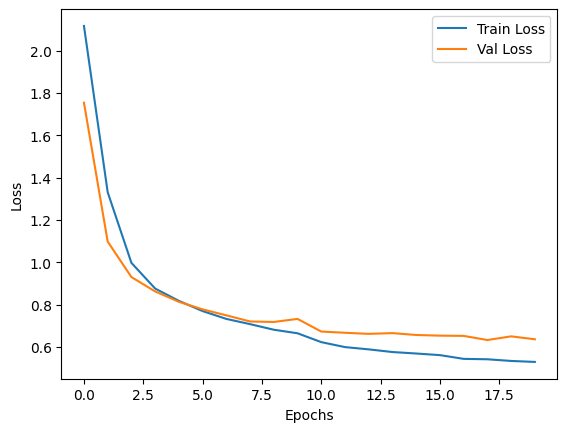

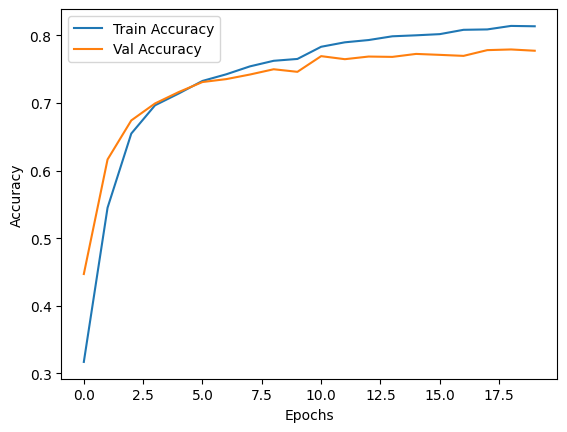

In [46]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_2.to(DEVICE)

# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

history = train(model_2, trainloader, valloader, optimizer,step_size=10 , epochs=20, verbose=True)

plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(history["train_acc"], label="Train Accuracy")
plt.plot(history["val_acc"], label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [54]:
filename = 'cifar10_model_2.pth'

torch.save(model_2.state_dict(), filename)
print(f"Model saved to {filename}")

Model saved to cifar10_model_2.pth


In [48]:
# model_2 = torch.load(filename)
# model_2.eval()
# print(f"Model loaded from {filename}")

## test

In [53]:
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)
test_loss, test_acc = test(model_2, testloader)

# Optionally, store these metrics for later analysis
history["test_loss"] = test_loss
history["test_acc"] = test_acc

Testing: 100%|██████████| 79/79 [00:11<00:00,  6.76it/s]

Test Loss: 0.6437, Test Accuracy: 0.7784


## statistics


In [50]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

model_2.eval()  # Set model to evaluation mode
all_labels = []
all_preds = []

misclassified_images = []
misclassified_labels = []
misclassified_preds = []

with torch.no_grad():
    for images, labels in tqdm(testloader, desc="Computing Confusion Matrix"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model_2(images)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())  # Collect all true labels
        all_preds.extend(preds.cpu().numpy())    # Collect all predictions

        # Find misclassified images
        incorrect = preds != labels
        misclassified_images.extend(images[incorrect].cpu())  # Collect misclassified images
        misclassified_labels.extend(labels[incorrect].cpu())  # True labels of misclassified images
        misclassified_preds.extend(preds[incorrect].cpu())  # Predicted labels of misclassified images



Computing Confusion Matrix: 100%|██████████| 79/79 [00:09<00:00,  7.96it/s]


Accuracy for class 0: 0.81
Accuracy for class 1: 0.90
Accuracy for class 2: 0.75
Accuracy for class 3: 0.61
Accuracy for class 4: 0.73
Accuracy for class 5: 0.71
Accuracy for class 6: 0.84
Accuracy for class 7: 0.79
Accuracy for class 8: 0.85
Accuracy for class 9: 0.81


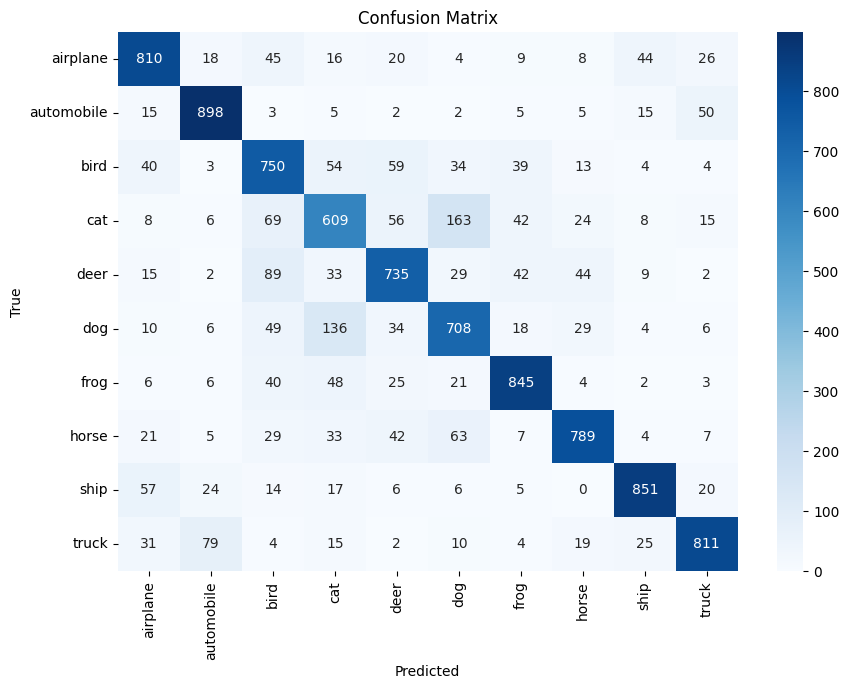

In [51]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Calculate accuracy for each class
class_accuracies = np.diag(cm) / cm.sum(axis=1)
for i, acc in enumerate(class_accuracies):
    print(f'Accuracy for class {i}: {acc:.2f}')

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=testloader.dataset.classes, yticklabels=testloader.dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

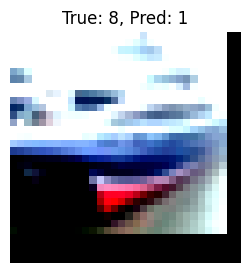

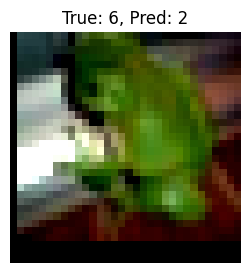

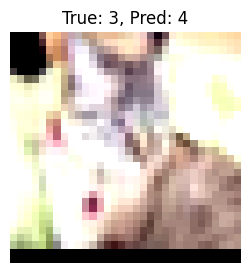

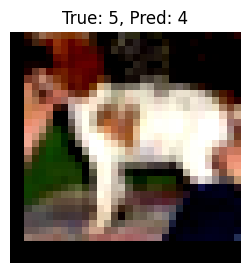

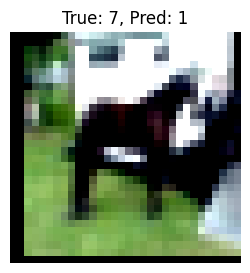

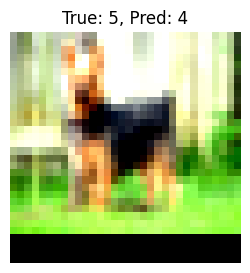

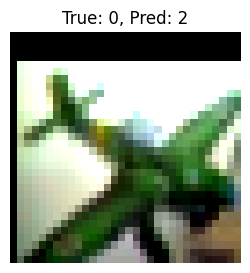

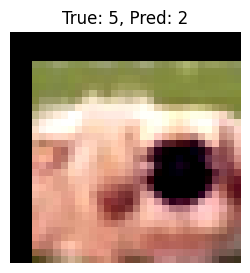

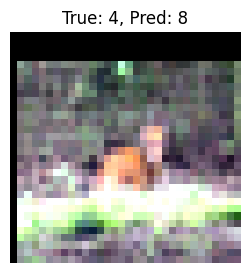

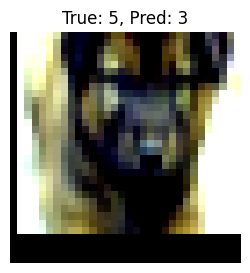

In [52]:
mean = torch.tensor([0.5, 0.5, 0.5])
std = torch.tensor([0.5, 0.5, 0.5])

num_images = 10

for i in range(num_images):
    # Create a new figure for each image
    plt.figure(figsize=(3, 3))

    image = misclassified_images[i].permute(1, 2, 0)  # Convert to (H, W, C)
    image = image * std + mean  # Unnormalize
    image = image.numpy()  # Convert to numpy
    image = np.clip(image, 0, 1)  # Ensure values are in [0, 1]

    plt.imshow(image)
    plt.title(f"True: {misclassified_labels[i]}, Pred: {misclassified_preds[i]}")
    plt.axis('off')  # Hide axes
    plt.show()  # Show each image independently